In [1]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from scipy import interp
plt.style.use('ggplot')

from sklearn.ensemble import RandomForestClassifier
from  sklearn.linear_model import LogisticRegression as LR
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

## Evaluation at Netflow level
Below is the evaluation of the data at netflow level using a random forest classifier and ADASYN resampler to take care of the class imbalance inherent

In [2]:
def evaluate_binary_classification(y_true, y_predict):
    conmat = confusion_matrix(y_true, y_predict)
    if len(conmat) == 1:
        TN, FP, FN, TP = (0, 0, 0, 0)
        if max(y_predict) == 0:
            # In this case, accuracy is 100% and all predictions are true negatives
            TN = conmat[0][0]
        elif min(y_predict) == 1:
            # In this case, accuracy is 100% and all predictions are true positives
            TP = conmat[0][0]
    else:
        TN, FP, FN, TP = conmat.ravel()

    print('TP: ' + str(TP))
    print('FP: ' + str(FP))
    print('FN: ' + str(FN))
    print('TN: ' + str(TN))
    
    #Evaluation flow level
    acc= accuracy_score(y_predict,y_true)*100
    f1= f1_score(y_predict,y_true)*100
    rec= recall_score(y_predict,y_true)*100
    prec=precision_score(y_predict,y_true)*100
    
    print("Accuracy:","%.2f" % acc)
    print("Precision:","%.2f" % prec)
    print("Recall:", "%.2f" %rec)
    print("F_score:","%.2f" % f1)


    return TP, FP, FN, TN

In [3]:
def rates(cm):
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0
    tot_TN = 0
    for i, (TP, FP, FN, TN) in enumerate(cm):
        tot_TP = tot_TP + TP
        tot_FP = tot_FP + FP
        tot_FN = tot_FN + FN
        tot_TN = tot_TN + TN

    print("TP:",tot_TP)
    print("FP:",tot_FP)
    print("TN:",tot_TN)
    print("FN:",tot_FN)

In [4]:
def loaddata(path):
    df = pd.read_table(path,
                       delim_whitespace=True,
                       header=None,
                       skiprows=1,
                       names=[
                                'Date_flow',
                                'Start',
                                'Durat',
                                'Prot',
                                'Src_IP_Addr:Port',
                                '->',
                                'Dst_IP_Addr:Port',
                                'Flags',
                                'Tos',
                                'Packets',
                                'Bytes',
                                'Flows',
                                'Label'
                            ])
    # Filter out background traffic
    df = df.loc[df['Label'] != 'Background']



    # Split ip adresses and ports
    src_ip_port = df['Src_IP_Addr:Port'].str \
        .split(':', expand=True) \
        .rename({0: 'Src_IP', 1: 'Src_Port'}, axis='columns')[['Src_IP', 'Src_Port']]
    dst_ip_port = df['Dst_IP_Addr:Port'].str \
        .split(':', expand=True) \
        .rename({0: 'Dst_IP', 1: 'Dst_Port'}, axis='columns')[['Dst_IP', 'Dst_Port']]
    
    df[src_ip_port.columns] = src_ip_port
    df[dst_ip_port.columns] = dst_ip_port
    # Drop useless columns
    df = df.drop(columns=['Src_IP_Addr:Port', '->', 'Dst_IP_Addr:Port'])

    return df

In [5]:
def loaddata_cat(df):
        # Select one-hot encodable columns
    oh_select = [
        'Prot',
        'Flags',
        'Tos',
        'Flows',
    ]

    # One hot encode
    oh_data = pd.get_dummies(df, columns=oh_select)

    # Only select numeric columns
    num_data = oh_data._get_numeric_data()

    # Add labels back in
    labels = df['Label'].apply(lambda i: 1 if i == 'Botnet' else 0)
    num_data['Label'] = labels
    return num_data

In [6]:
df_clean = loaddata('dataset/capture20110818.pcap.netflow.labeled')
df_clean_copy = df_clean.copy()


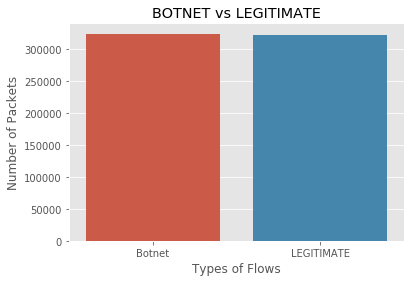

Number of Botnet:  323441
Number of Legitimate:  321917
Ratio:  1.0047341395452865


In [7]:
# Check for imbalance
ax = df_clean['Label'].value_counts()
plt.title('BOTNET vs LEGITIMATE')
sns.barplot(x=ax.index, y= ax)  
plt.xlabel('Types of Flows')
plt.ylabel('Number of Packets')
plt.show()

val_1 = len(df_clean[df_clean['Label'] == 'Botnet'])
val_2 = len(df_clean[df_clean['Label'] == 'LEGITIMATE'])
print("Number of Botnet: ", val_1)
print("Number of Legitimate: ", val_2)
print("Ratio: ", val_1/val_2)
ratio = val_1/val_2
if ratio > 3 or ratio < 0.5:
    resampling = True
else:
    resampling = False

### below we do the one hot encoding of the data set (which can take a long time)

In [8]:
df_clean = loaddata_cat(df_clean)
labels = df_clean['Label']
df_clean = df_clean.loc[:, df_clean.columns != 'Label']
df_clean

,Durat,Packets,Bytes,Prot_ICMP,Prot_TCP,Prot_UDP,Flags_AHA,Flags_A_,Flags_DCE,Flags_DNP,...,Flags_URPRE,Flags_URS,Flags_WAY,Flags__FSA,Flags__FSPA,Flags__FSRA,Flags__FSRPA,Flags____,Tos_0,Flows_1
20,4.985,91,86277,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
51,0.000,1,66,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
57,4.921,49,3234,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
73,4.742,118,7080,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
75,0.000,1,60,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
127,4.434,30,1980,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
193,0.000,1,66,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
196,0.174,5,559,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
257,0.009,2,120,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
268,0.000,1,66,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1


In [9]:
# Do K-Fold cross validation, set random_state for repeatability
folds = 10
rs = 1337
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rs)

df_clean

,Durat,Packets,Bytes,Prot_ICMP,Prot_TCP,Prot_UDP,Flags_AHA,Flags_A_,Flags_DCE,Flags_DNP,...,Flags_URPRE,Flags_URS,Flags_WAY,Flags__FSA,Flags__FSPA,Flags__FSRA,Flags__FSRPA,Flags____,Tos_0,Flows_1
20,4.985,91,86277,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
51,0.000,1,66,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
57,4.921,49,3234,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
73,4.742,118,7080,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
75,0.000,1,60,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
127,4.434,30,1980,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
193,0.000,1,66,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
196,0.174,5,559,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
257,0.009,2,120,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
268,0.000,1,66,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1


In [10]:
 def predict_binary(data, threshold, classifier):
        return [1 if x > threshold else 0 for x in classifier.predict_proba(data)[:,1]]

In [11]:
#Function to do a k fold cross validation for a classifier
def k_fold(classifier, df_clean, labels, folds, resampling, classifier_name):
    conf_results = []
    ROC_results = []
    x_tests = []
    y_tests = []
    y_preds = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    print("Using {}-fold crossvalidation".format(folds))
    for idx, (train_index, test_index) in enumerate(kf.split(df_clean, labels)):
        print("Fold {}/{}:".format(idx + 1, folds),)

        # Select training and test data using split indexes
        train = df_clean.iloc[train_index]
        test = df_clean.iloc[test_index]

        if resampling:
            # SMOTE/ADASYN resample - Use if a data imbalance exists
            x_resampled, y_resampled = ADASYN(random_state=rs).fit_sample(train, labels.iloc[train_index])
        else:
            x_resampled, y_resampled = train, labels.iloc[train_index]

        # Train classifier
        classifier.fit(x_resampled, y_resampled)
        probas_ = classifier.predict_proba(test)
        fpr, tpr, thresholds = roc_curve(labels.iloc[test_index], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (idx, roc_auc))

        # Prepare test data
        x_test = test
        y_test = labels.iloc[test_index]
        
        y_predict = classifier.predict(x_test)
        

        ROC_results.append(roc_curve(y_test, y_predict))

        # Get predictions
        y_predict_binary = predict_binary(x_test, classifier_threshold, classifier)

        conf_results.append(evaluate_binary_classification(y_test, y_predict_binary))
        x_tests.append(x_test)
        y_tests.append(y_test)
        y_preds.append(y_predict)
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
                 label='Chance', alpha=.8)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("{} classifier (depth = {})".format(classifier_name, depth) + ", " + str(folds) + " folds - ")
    plt.legend(loc="lower right", fontsize = 'x-small')
    plt.show()
    
    return conf_results

## Classification packet level

we use 2 classifiers:

- Random forest
- Logistic regression

Using 10-fold crossvalidation
Fold 1/10:
TP: 32295
FP: 301
FN: 50
TN: 31891
Accuracy: 99.46
Precision: 99.85
Recall: 99.08
F_score: 99.46
Fold 2/10:
TP: 32292
FP: 329
FN: 52
TN: 31863
Accuracy: 99.41
Precision: 99.84
Recall: 98.99
F_score: 99.41
Fold 3/10:
TP: 32291
FP: 303
FN: 53
TN: 31889
Accuracy: 99.45
Precision: 99.84
Recall: 99.07
F_score: 99.45
Fold 4/10:
TP: 32300
FP: 321
FN: 44
TN: 31871
Accuracy: 99.43
Precision: 99.86
Recall: 99.02
F_score: 99.44
Fold 5/10:
TP: 32283
FP: 318
FN: 61
TN: 31874
Accuracy: 99.41
Precision: 99.81
Recall: 99.02
F_score: 99.42
Fold 6/10:
TP: 32290
FP: 341
FN: 54
TN: 31851
Accuracy: 99.39
Precision: 99.83
Recall: 98.95
F_score: 99.39
Fold 7/10:
TP: 32293
FP: 267
FN: 51
TN: 31925
Accuracy: 99.51
Precision: 99.84
Recall: 99.18
F_score: 99.51
Fold 8/10:
TP: 32274
FP: 305
FN: 70
TN: 31886
Accuracy: 99.42
Precision: 99.78
Recall: 99.06
F_score: 99.42
Fold 9/10:
TP: 32282
FP: 311
FN: 62
TN: 31880
Accuracy: 99.42
Precision: 99.81
Recall: 99.05
F_score: 99.4

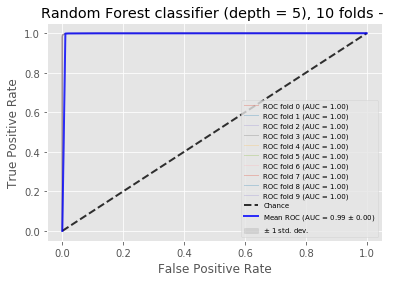

TP: 322897
FP: 3115
TN: 318802
FN: 544


In [12]:
# Initialize Random Forest classifier with depth 5
depth = 5
rf = RandomForestClassifier(depth, random_state=42)
classifier_threshold = 0.3
cm = k_fold(rf,df_clean,labels, folds,resampling,'Random Forest')
rates(cm)


Using 10-fold crossvalidation
Fold 1/10:
TP: 32178
FP: 31897
FN: 167
TN: 295
Accuracy: 50.32
Precision: 99.48
Recall: 50.22
F_score: 66.75
Fold 2/10:
TP: 32141
FP: 31906
FN: 203
TN: 286
Accuracy: 50.25
Precision: 99.37
Recall: 50.18
F_score: 66.69
Fold 3/10:
TP: 31586
FP: 1060
FN: 758
TN: 31132
Accuracy: 97.18
Precision: 97.66
Recall: 96.75
F_score: 97.20
Fold 4/10:
TP: 32173
FP: 31904
FN: 171
TN: 288
Accuracy: 50.30
Precision: 99.47
Recall: 50.21
F_score: 66.73
Fold 5/10:
TP: 32156
FP: 31886
FN: 188
TN: 306
Accuracy: 50.30
Precision: 99.42
Recall: 50.21
F_score: 66.72
Fold 6/10:
TP: 32182
FP: 31925
FN: 162
TN: 267
Accuracy: 50.28
Precision: 99.50
Recall: 50.20
F_score: 66.73
Fold 7/10:
TP: 32163
FP: 31901
FN: 181
TN: 291
Accuracy: 50.29
Precision: 99.44
Recall: 50.20
F_score: 66.72
Fold 8/10:
TP: 32175
FP: 31945
FN: 169
TN: 246
Accuracy: 50.24
Precision: 99.48
Recall: 50.18
F_score: 66.71
Fold 9/10:
TP: 32163
FP: 31945
FN: 181
TN: 246
Accuracy: 50.22
Precision: 99.44
Recall: 50.17
F_s

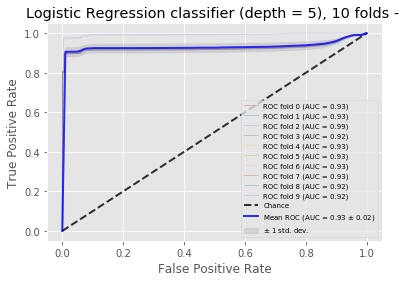

TP: 321086
FP: 288292
TN: 33625
FN: 2355


In [14]:

classifier_threshold = 0.25
clf = LR(C = 1, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)
cm = k_fold(clf, df_clean, labels, folds, resampling,'Logistic Regression')
rates(cm)

## Evaluation at host level
Below is the evaluation of the data at host level

In [15]:
label_mapping={}
label_mapping['Label'] = {'LEGITIMATE': 0, 'Botnet' : 1}
df_clean_copy.replace({'Label' : label_mapping['Label']}, inplace=True)
char_cols =  df_clean_copy.dtypes.pipe(lambda x: x[x == 'object']).index
for c in char_cols:
    df_clean_copy[c], label_mapping[c] = pd.factorize( df_clean_copy[c])

In [16]:
df_perhost = df_clean_copy.groupby(by='Src_IP').agg({'Durat':'sum', 'Prot':'sum', 'Flags':'sum', 'Tos':'sum', 'Packets':'sum', 'Bytes':'sum', 'Flows':'sum', 'Label':'max'})
df_perhost['Dst_IPs'] = df_clean_copy.groupby('Src_IP')['Dst_IP'].nunique()
df_perhost['Src_Ports'] = df_clean_copy.groupby('Src_IP')['Src_Port'].nunique()
df_perhost['Dst_Ports'] = df_clean_copy.groupby('Src_IP')['Dst_Port'].nunique()

hosts = df_perhost.index

df_perhost

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Dst_IPs,Src_Ports,Dst_Ports
Src_IP,,,,,,,,,,,
0,36118.226,0,67083,0,3057764,4113893358,36949,0,53,16,6104
1,2433.508,0,3672,0,10667,4287341,2921,0,43,325,2
2,14737.020,0,76580,0,233738,59270611,11801,0,4,4640,2
3,45904.780,194,287231,0,710691,312132150,90560,0,208,14179,11
4,6585.936,3452,36352,0,50649,10206525,10910,0,155,2856,22
5,1580.394,0,10681,0,26270,6987602,2945,0,49,1151,3
6,1409.703,0,8144,0,7630,1866307,2665,0,43,621,4
7,617.824,0,3711,0,6878,1893798,1699,0,35,258,2
8,431.367,0,1900,0,4344,1007591,1800,0,56,188,4


In [17]:
infected_hosts = ["147.32.84.165", "147.32.84.191", "147.32.84.192", "147.32.84.193", "147.32.84.204", "147.32.84.205", "147.32.84.206", "147.32.84.207", "147.32.84.208", "147.32.84.209"]
normal_hosts = ["147.32.84.170", "147.32.84.134", "147.32.84.164", "147.32.87.36", "147.32.80.9"]

In [18]:
labels = df_perhost['Label']
df_perhost = df_perhost.loc[:, df_perhost.columns != 'Label']

In [19]:
depth = 5
folds = 10
rs = 1337
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rs)

Using 10-fold crossvalidation
Fold 1/10:
TP: 7
FP: 1
FN: 0
TN: 45
Accuracy: 98.11
Precision: 100.00
Recall: 87.50
F_score: 93.33
Fold 2/10:
TP: 6
FP: 3
FN: 1
TN: 43
Accuracy: 92.45
Precision: 85.71
Recall: 66.67
F_score: 75.00
Fold 3/10:
TP: 5
FP: 3
FN: 2
TN: 43
Accuracy: 90.57
Precision: 71.43
Recall: 62.50
F_score: 66.67
Fold 4/10:
TP: 5
FP: 5
FN: 2
TN: 41
Accuracy: 86.79
Precision: 71.43
Recall: 50.00
F_score: 58.82
Fold 5/10:
TP: 6
FP: 1
FN: 1
TN: 45
Accuracy: 96.23
Precision: 85.71
Recall: 85.71
F_score: 85.71
Fold 6/10:
TP: 7
FP: 4
FN: 0
TN: 41
Accuracy: 92.31
Precision: 100.00
Recall: 63.64
F_score: 77.78
Fold 7/10:
TP: 5
FP: 5
FN: 2
TN: 40
Accuracy: 86.54
Precision: 71.43
Recall: 50.00
F_score: 58.82
Fold 8/10:
TP: 3
FP: 2
FN: 3
TN: 43
Accuracy: 90.20
Precision: 50.00
Recall: 60.00
F_score: 54.55
Fold 9/10:
TP: 5
FP: 2
FN: 1
TN: 43
Accuracy: 94.12
Precision: 83.33
Recall: 71.43
F_score: 76.92
Fold 10/10:
TP: 5
FP: 4
FN: 1
TN: 41
Accuracy: 90.20
Precision: 83.33
Recall: 55.56
F_

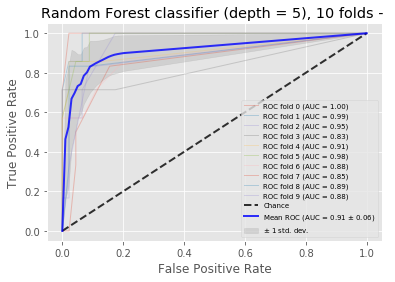

TP: 54
FP: 30
TN: 425
FN: 13


In [20]:
rf = RandomForestClassifier(depth, random_state=42)
classifier_threshold = 0.3
cm = k_fold(rf,df_perhost,labels, folds,resampling,'Random Forest')
rates(cm)

Using 10-fold crossvalidation
Fold 1/10:
TP: 5
FP: 26
FN: 2
TN: 20
Accuracy: 47.17
Precision: 71.43
Recall: 16.13
F_score: 26.32
Fold 2/10:
TP: 5
FP: 28
FN: 2
TN: 18
Accuracy: 43.40
Precision: 71.43
Recall: 15.15
F_score: 25.00
Fold 3/10:
TP: 7
FP: 23
FN: 0
TN: 23
Accuracy: 56.60
Precision: 100.00
Recall: 23.33
F_score: 37.84
Fold 4/10:
TP: 6
FP: 27
FN: 1
TN: 19
Accuracy: 47.17
Precision: 85.71
Recall: 18.18
F_score: 30.00
Fold 5/10:
TP: 6
FP: 23
FN: 1
TN: 23
Accuracy: 54.72
Precision: 85.71
Recall: 20.69
F_score: 33.33
Fold 6/10:
TP: 6
FP: 31
FN: 1
TN: 14
Accuracy: 38.46
Precision: 85.71
Recall: 16.22
F_score: 27.27
Fold 7/10:
TP: 7
FP: 28
FN: 0
TN: 17
Accuracy: 46.15
Precision: 100.00
Recall: 20.00
F_score: 33.33
Fold 8/10:
TP: 5
FP: 27
FN: 1
TN: 18
Accuracy: 45.10
Precision: 83.33
Recall: 15.62
F_score: 26.32
Fold 9/10:
TP: 6
FP: 25
FN: 0
TN: 20
Accuracy: 50.98
Precision: 100.00
Recall: 19.35
F_score: 32.43
Fold 10/10:
TP: 5
FP: 25
FN: 1
TN: 20
Accuracy: 49.02
Precision: 83.33
Recal

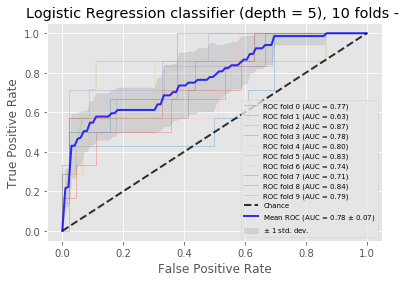

TP: 58
FP: 263
TN: 192
FN: 9


In [21]:
classifier_threshold = 0.2
clf = LR(C = 1, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)
cm = k_fold(clf, df_perhost, labels, folds, resampling,'Logistic Regression')
rates(cm)